## Aerial Object Classification

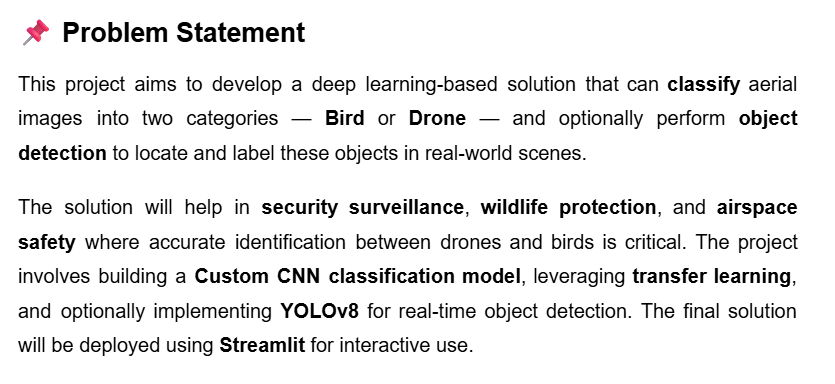

In [1]:
import pandas as pd
import numpy as np
import cv2
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras import layers, models
from keras.models import Model, Sequential
from keras.preprocessing import image, sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Convolution2D, Dropout, LSTM, TimeDistributed, Embedding, Bidirectional, BatchNormalization, Activation, RepeatVector, Concatenate
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve, auc
from keras.optimizers import Nadam

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
train_dir = '/content/drive/MyDrive/Colab Notebooks/Projects/AerialObjectClassification/classification_dataset/train'
val_dir = '/content/drive/MyDrive/Colab Notebooks/Projects/AerialObjectClassification/classification_dataset/valid'
test_dir = '/content/drive/MyDrive/Colab Notebooks/Projects/AerialObjectClassification/classification_dataset/test'

In [4]:
IMG_SIZE = (224, 224)
BATCH = 32
NUM_CLASSES = 2

Loading Data for train, validation and test

In [5]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    label_mode="categorical",
    batch_size=BATCH,
    image_size=IMG_SIZE,
    shuffle=True
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    label_mode="categorical",
    batch_size=BATCH,
    image_size=IMG_SIZE,
    shuffle=False
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    label_mode="categorical",
    batch_size=BATCH,
    image_size=IMG_SIZE,
    shuffle=False
)

Found 2662 files belonging to 2 classes.
Found 442 files belonging to 2 classes.
Found 215 files belonging to 2 classes.


Data Augmentation

In [6]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
    layers.RandomCrop(200, 200),
    layers.Resizing(224, 224),
])

Normalizing Pixel values from 0,255 to 0,1

In [7]:
normalization = layers.Rescaling(1./255)

train_ds = train_ds.map(lambda x, y: (normalization(data_augmentation(x)), y))
val_ds   = val_ds.map(lambda x, y: (normalization(x), y))
test_ds  = test_ds.map(lambda x, y: (normalization(x), y))

train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds   = val_ds.prefetch(tf.data.AUTOTUNE)
test_ds  = test_ds.prefetch(tf.data.AUTOTUNE)

Build CNN Classifier

In [8]:
def build_custom_cnn(input_shape=(224, 224, 3), num_classes=2):
    model = models.Sequential([
        layers.Input(shape=input_shape),

        layers.Conv2D(32, (3,3), padding="same", activation="relu"),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),

        layers.Conv2D(64, (3,3), padding="same", activation="relu"),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),

        layers.Conv2D(128, (3,3), padding="same", activation="relu"),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),

        layers.Flatten(),

        layers.Dense(256, activation="relu"),
        layers.BatchNormalization(),
        layers.Dropout(0.4),

        layers.Dense(num_classes, activation="softmax")   # Dense output layer
    ])

    return model

cnn_model = build_custom_cnn()
cnn_model.summary()

cnn_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    25,690,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,786,050 (98.37 MB)

 Trainable params: 25,785,090 (98.36 MB)

 Non-trainable params: 960 (3.75 KB)

Transfer Learning Model with ResNet

In [9]:
def build_resnet50_model(num_classes=2):

    base_model = ResNet50(
        weights="imagenet",
        include_top=False,
        input_shape=(224, 224, 3)
    )
    base_model.trainable = False   # freeze for transfer learning

    inputs = layers.Input(shape=(224, 224, 3))
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)

    x = layers.Dense(256, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = models.Model(inputs, outputs)
    return model

resnet_model = build_resnet50_model()
resnet_model.summary()

resnet_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,113,794 (91.99 MB)

 Trainable params: 525,570 (2.00 MB)

 Non-trainable params: 23,588,224 (89.98 MB)

Train CNN Classifier Model

In [10]:
history_cnn = cnn_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

Epoch 1/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 201s 2s/step - accuracy: 0.6905 - loss: 1.0980 - val_accuracy: 0.6652 - val_loss: 0.6351
Epoch 2/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 44s 515ms/step - accuracy: 0.7683 - loss: 0.5564 - val_accuracy: 0.6448 - val_loss: 0.7526
Epoch 3/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 44s 517ms/step - accuracy: 0.8022 - loss: 0.4762 - val_accuracy: 0.6674 - val_loss: 0.8308
Epoch 4/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 43s 510ms/step - accuracy: 0.7842 - loss: 0.4959 - val_accuracy: 0.6810 - val_loss: 0.8365
Epoch 5/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 44s 519ms/step - accuracy: 0.8322 - loss: 0.4019 - val_accuracy: 0.7262 - val_loss: 0.7122
Epoch 6/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 45s 527ms/step - accuracy: 0.8246 - loss: 0.3981 - val_accuracy: 0.7783 - val_loss: 0.5798
Epoch 7/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 46s 544ms/step - accuracy: 0.8328 - loss: 0.4283 - val_accuracy: 0.8167 - val_loss: 0.4779
Epoch 8/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 45s 526ms/step - accuracy: 0.8346 - loss: 0.3854 - val_accura

Train ResNet Model

In [11]:
history_resnet = resnet_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

Epoch 1/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 74s 711ms/step - accuracy: 0.6466 - loss: 0.6507 - val_accuracy: 0.4910 - val_loss: 0.8447
Epoch 2/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 46s 537ms/step - accuracy: 0.6980 - loss: 0.5732 - val_accuracy: 0.5520 - val_loss: 0.6889
Epoch 3/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 45s 538ms/step - accuracy: 0.7337 - loss: 0.5395 - val_accuracy: 0.7602 - val_loss: 0.5756
Epoch 4/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 46s 539ms/step - accuracy: 0.7243 - loss: 0.5461 - val_accuracy: 0.6719 - val_loss: 0.5863
Epoch 5/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 46s 542ms/step - accuracy: 0.7432 - loss: 0.5275 - val_accuracy: 0.6425 - val_loss: 0.6412
Epoch 6/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 81s 530ms/step - accuracy: 0.7268 - loss: 0.5366 - val_accuracy: 0.7896 - val_loss: 0.4731
Epoch 7/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 45s 538ms/step - accuracy: 0.7329 - loss: 0.5275 - val_accuracy: 0.6584 - val_loss: 0.6144
Epoch 8/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 46s 538ms/step - accuracy: 0.7418 - loss: 0.5215 - val_accu

Finetune ResNet Model

In [12]:
resnet_model.layers[1].trainable = True

for layer in resnet_model.layers[1].layers[:100]:
    layer.trainable = False

resnet_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

history_finetune = resnet_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5
)

Epoch 1/5
84/84 ━━━━━━━━━━━━━━━━━━━━ 101s 788ms/step - accuracy: 0.6400 - loss: 0.7843 - val_accuracy: 0.6176 - val_loss: 0.8451
Epoch 2/5
84/84 ━━━━━━━━━━━━━━━━━━━━ 48s 562ms/step - accuracy: 0.7188 - loss: 0.5844 - val_accuracy: 0.5045 - val_loss: 1.9037
Epoch 3/5
84/84 ━━━━━━━━━━━━━━━━━━━━ 48s 563ms/step - accuracy: 0.7317 - loss: 0.5806 - val_accuracy: 0.5520 - val_loss: 1.4465
Epoch 4/5
84/84 ━━━━━━━━━━━━━━━━━━━━ 46s 548ms/step - accuracy: 0.7612 - loss: 0.5334 - val_accuracy: 0.5769 - val_loss: 0.9268
Epoch 5/5
84/84 ━━━━━━━━━━━━━━━━━━━━ 48s 561ms/step - accuracy: 0.7421 - loss: 0.5344 - val_accuracy: 0.7896 - val_loss: 0.5162


Evaluation of Models

In [13]:
print("CNN Test Accuracy:")
cnn_model.evaluate(test_ds)

print("ResNet50 Test Accuracy:")
resnet_model.evaluate(test_ds)

CNN Test Accuracy:
7/7 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - accuracy: 0.8129 - loss: 0.4550
ResNet50 Test Accuracy:
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 869ms/step - accuracy: 0.7489 - loss: 0.5215


[0.49738001823425293, 0.7627906799316406]

Visualizing Results

Accuracy and Loss Comparison of Both CNN and ResNet models

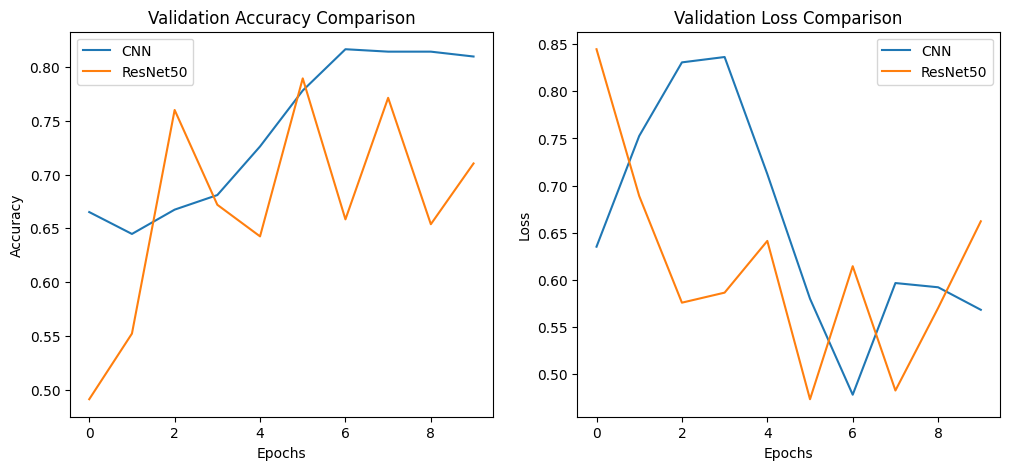

In [14]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history_cnn.history["val_accuracy"], label="CNN")
plt.plot(history_resnet.history["val_accuracy"], label="ResNet50")
plt.title("Validation Accuracy Comparison")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_cnn.history["val_loss"], label="CNN")
plt.plot(history_resnet.history["val_loss"], label="ResNet50")
plt.title("Validation Loss Comparison")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

Confusion Matrix for CNN Model

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 926ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 529ms/step


<Figure size 600x600 with 0 Axes>

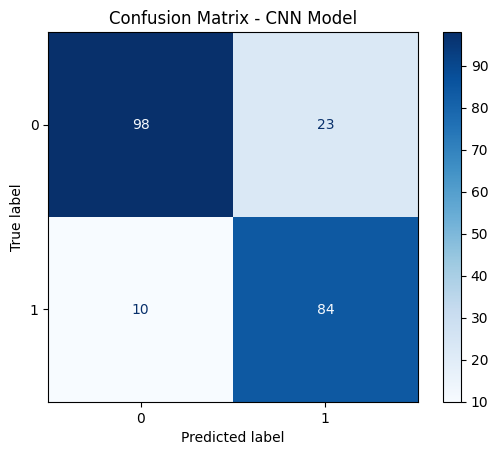

In [15]:
from sklearn.metrics import ConfusionMatrixDisplay

# ---- Collect predictions ----
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = cnn_model.predict(images)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues", values_format='d')
plt.title("Confusion Matrix - CNN Model")
plt.show()


Confusion Matrix for ResNet Model

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


<Figure size 600x600 with 0 Axes>

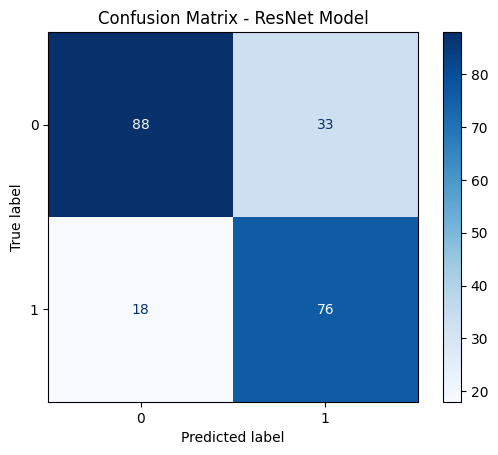

In [16]:
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = resnet_model.predict(images)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues", values_format='d')
plt.title("Confusion Matrix - ResNet Model")
plt.show()

ROC Curve for CNN model

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


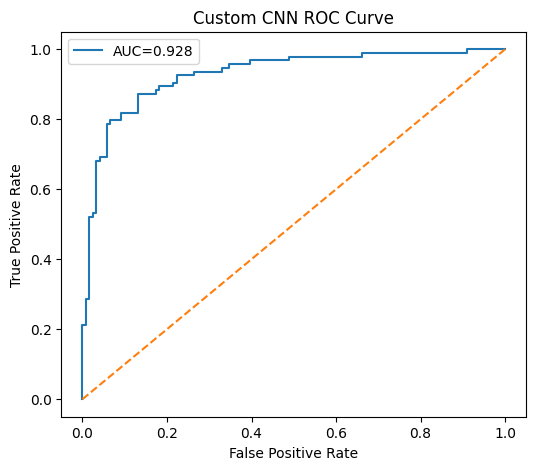

In [17]:
y_true = []
y_score = []

for images, labels in test_ds:
    preds = cnn_model.predict(images)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_score.extend(preds[:,1])

fpr, tpr, _ = roc_curve(y_true, y_score)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC={roc_auc:.3f}")
plt.plot([0,1],[0,1],'--')
plt.title("Custom CNN ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

ROC Curve for ResNet model

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


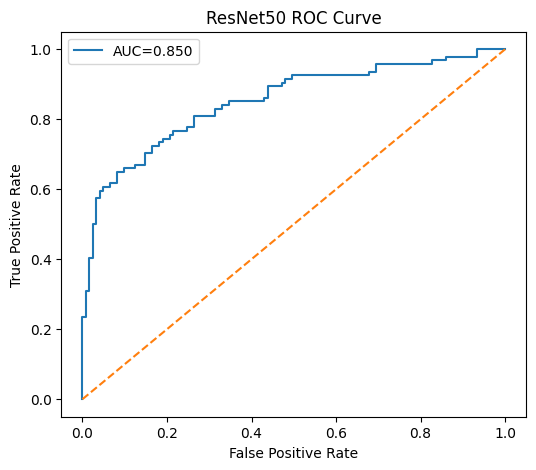

In [18]:
y_true = []
y_score = []

for images, labels in test_ds:
    preds = resnet_model.predict(images)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_score.extend(preds[:,1])

fpr, tpr, _ = roc_curve(y_true, y_score)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC={roc_auc:.3f}")
plt.plot([0,1],[0,1],'--')
plt.title("ResNet50 ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

Object Detection with YOLO v8

In [19]:
pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 19.2 MB/s eta 0:00:00


In [20]:
from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [21]:

DATASET_DRIVE_PATH = "/content/drive/MyDrive/Colab Notebooks/Projects/AerialObjectClassification/object_detection_Dataset"

!mkdir -p /content/dataset/

!cp -r $DATASET_DRIVE_PATH/* /content/dataset/

cp: cannot stat '/content/drive/MyDrive/Colab': No such file or directory
cp: cannot stat 'Notebooks/Projects/AerialObjectClassification/object_detection_Dataset/*': No such file or directory


In [22]:
import shutil, os

drive_dataset_path = "/content/drive/MyDrive/Colab Notebooks/Projects/AerialObjectClassification/object_detection_Dataset"

colab_dataset_path = "/content/YOLO_dataset"

# If folder exists already, remove it (optional)
#if os.path.exists(colab_dataset_path):
    #shutil.rmtree(colab_dataset_path)

shutil.copytree(drive_dataset_path, colab_dataset_path)

print("Dataset copied to:", colab_dataset_path)

Dataset copied to: /content/YOLO_dataset


In [23]:
model = YOLO("yolov8n.pt")

# Train
model.train(
    data="/content/YOLO_dataset/data.yaml",
    epochs=50,
    imgsz=640,
    batch=16
)

Ultralytics 8.3.233 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/YOLO_dataset/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pos

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7e3daf8304d0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04804

In [24]:
model = YOLO("runs/detect/train/weights/best.pt")

metrics = model.val(save_json=True, save_txt=True)

Ultralytics 8.3.233 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 698.1±244.0 MB/s, size: 24.2 KB)
val: Scanning /content/YOLO_dataset/valid/labels.cache... 448 images, 6 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 448/448 900.4Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 28/28 2.9it/s 9.8s
                   all        448        663      0.849      0.779      0.825       0.53
                  Bird        217        414      0.812       0.65      0.723      0.422
                 drone        225        249      0.886      0.908      0.927      0.639
Speed: 2.1ms preprocess, 4.1ms inference, 0.0ms loss, 1.3ms postprocess per image
Saving /content/runs/detect/val/predictions.json...
Results saved to /content/runs/detect/val


Plotting Performance of YOLO

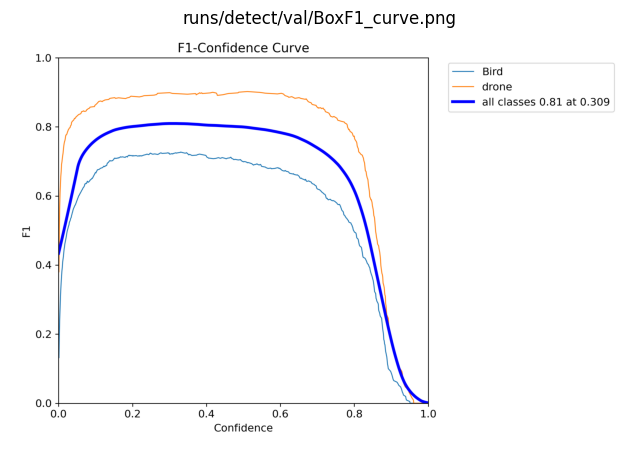

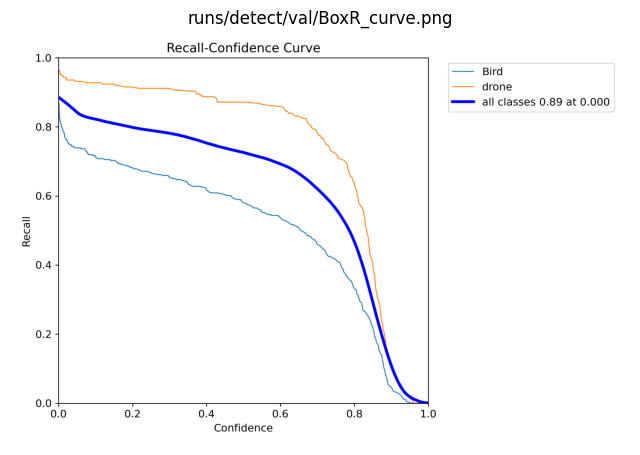

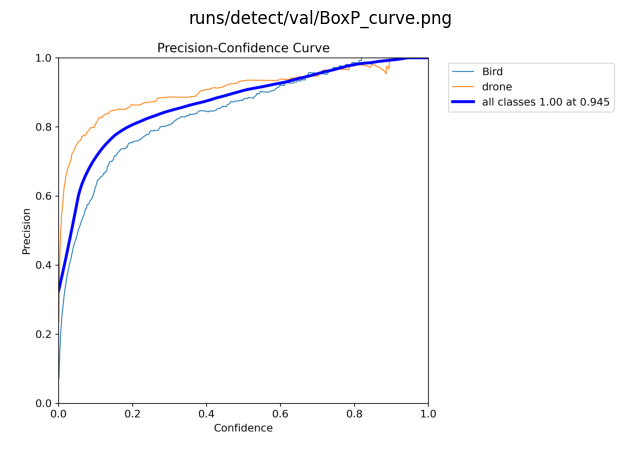

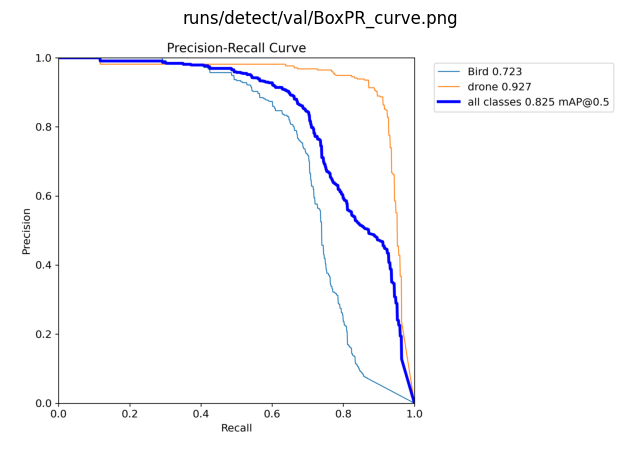

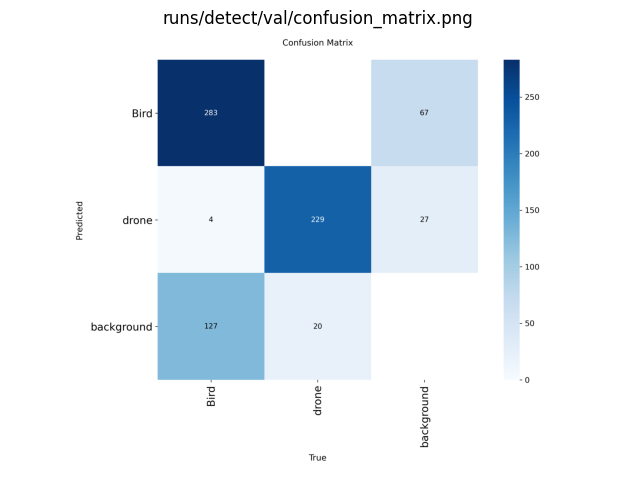

In [25]:
import glob
from PIL import Image

result_imgs = glob.glob("runs/detect/val/*curve*.png") + \
              glob.glob("runs/detect/val/confusion_matrix.png") + \
              glob.glob("runs/detect/val/confusion.png")

for img_path in result_imgs:
    img = Image.open(img_path)
    plt.figure(figsize=(8,6))
    plt.imshow(img)
    plt.axis("off")
    plt.title(img_path)

In [26]:
results = model.predict(
    source='/content/YOLO_dataset/test/images',
    save=True,
    save_txt=True,
    conf=0.25
)


image 1/224 /content/YOLO_dataset/test/images/00083b384685315d_jpg.rf.abfd1b2cc8c681777bae66d5327bb9ea.jpg: 640x640 1 Bird, 18.6ms
image 2/224 /content/YOLO_dataset/test/images/00188d7f40a84793_jpg.rf.7f9da2b662dc236fbdcc1f22d8e0983e.jpg: 640x640 1 Bird, 12.6ms
image 3/224 /content/YOLO_dataset/test/images/0028adf0e92c3da2_jpg.rf.48c97d30547a46e83abcbd1bf801c72f.jpg: 640x640 1 Bird, 9.2ms
image 4/224 /content/YOLO_dataset/test/images/00347cbbeed4bedb_jpg.rf.aa19c9a7a22d76f8539ca12ac7cb82d5.jpg: 640x640 1 Bird, 7.3ms
image 5/224 /content/YOLO_dataset/test/images/004cc8de466969bc_jpg.rf.ca1ffa31f30a92a3987e689583983973.jpg: 640x640 1 Bird, 7.3ms
image 6/224 /content/YOLO_dataset/test/images/006ce62a72df4dd4_jpg.rf.8f8e7b6e9a26a01be91ea1b7dc4011d2.jpg: 640x640 (no detections), 7.3ms
image 7/224 /content/YOLO_dataset/test/images/006f6769070fc876_jpg.rf.bda2b07a999cd589936497151e0d009f.jpg: 640x640 2 Birds, 8.9ms
image 8/224 /content/YOLO_dataset/test/images/007321d46c4b8ffe_jpg.rf.bdea1bd

Plot Test Results

In [27]:
print("📌 Evaluation on Test Dataset:")
print(f"mAP50-95: {metrics.box.map:.4f}")
print(f"mAP50:    {metrics.box.map50:.4f}")
print(f"mAP75:    {metrics.box.map75:.4f}")
print("\nAP per Class:")

for cls_id, ap in enumerate(metrics.box.maps):
    print(f"Class {cls_id}: AP = {ap:.4f}")

📌 Evaluation on Test Dataset:
mAP50-95: 0.5304
mAP50:    0.8253
mAP75:    0.5781

AP per Class:
Class 0: AP = 0.4217
Class 1: AP = 0.6392


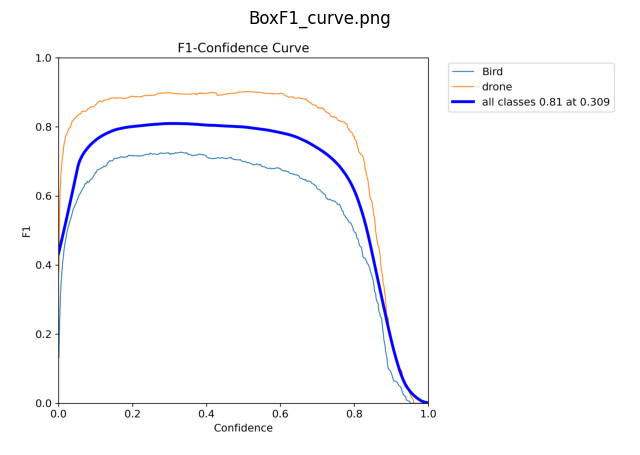

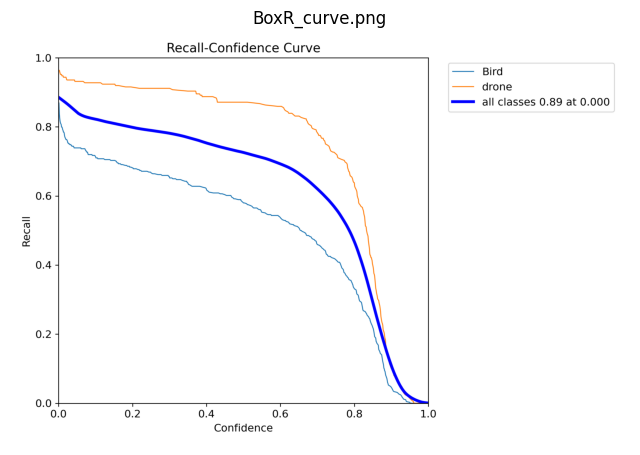

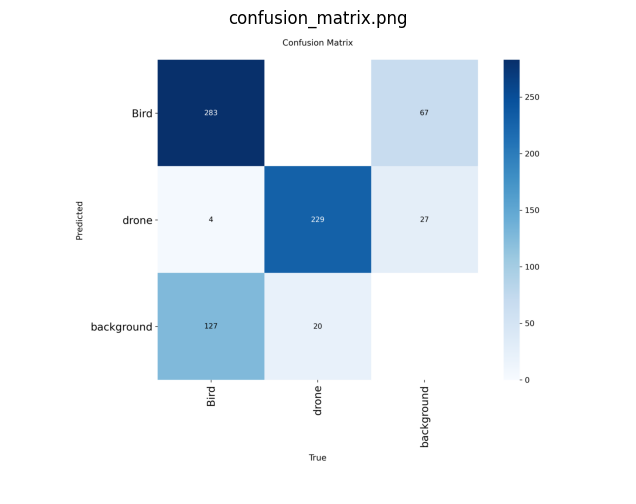

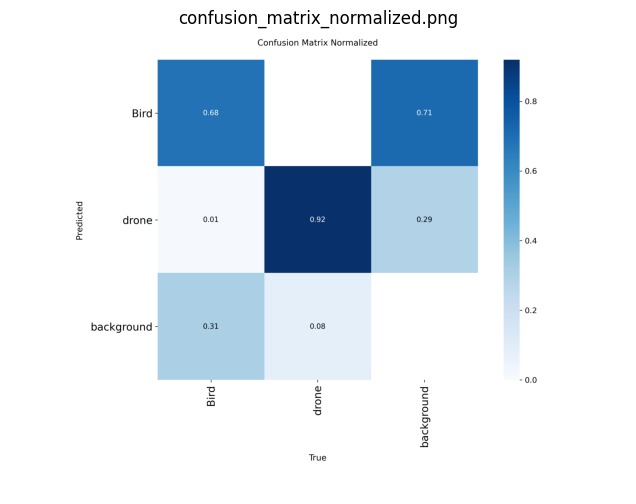

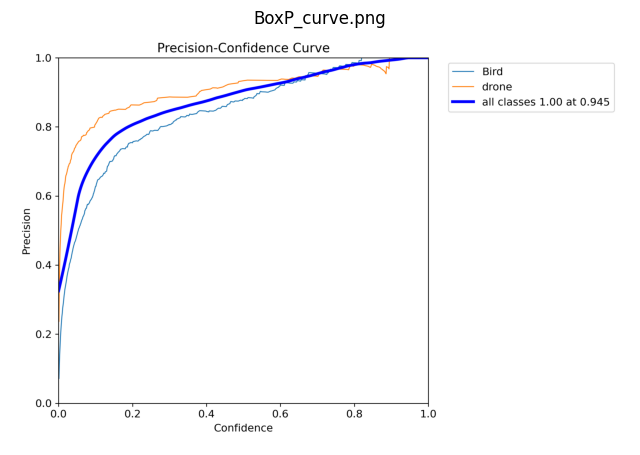

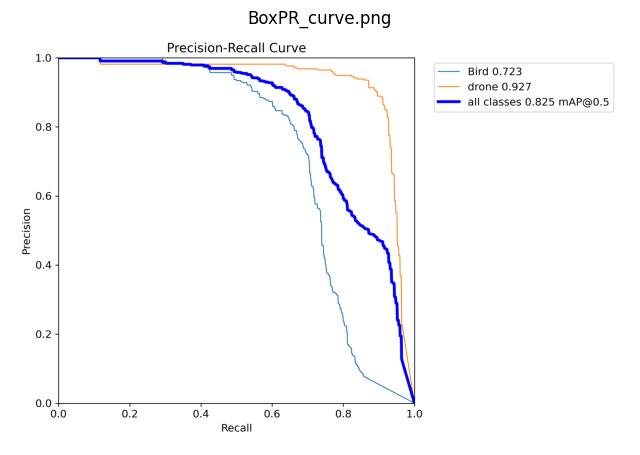

In [28]:
evaluation_plots = glob.glob("runs/detect/val/*.png")

for img_path in evaluation_plots:
    img = Image.open(img_path)
    plt.figure(figsize=(8,6))
    plt.imshow(img)
    plt.axis("off")
    plt.title(img_path.split("/")[-1])

In [29]:
yolo_model = model

In [34]:
os.makedirs("models", exist_ok=True)
cnn_model.save("models/cnn_model.keras")
resnet_model.save("models/resnet_model.keras")
yolo_model = YOLO("/content/yolov8n.pt")
yolo_model.export(format="onnx")

Ultralytics 8.3.233 🚀 Python-3.12.12 torch-2.9.0+cu126 CPU (Intel Xeon CPU @ 2.30GHz)
💡 ProTip: Export to OpenVINO format for best performance on Intel hardware. Learn more at https://docs.ultralytics.com/integrations/openvino/
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs

PyTorch: starting from '/content/yolov8n.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 84, 8400) (6.2 MB)
requirements: Ultralytics requirements ['onnx>=1.12.0,<=1.19.1', 'onnxslim>=0.1.71', 'onnxruntime-gpu'] not found, attempting AutoUpdate...
Using Python 3.12.12 environment at: /usr
Resolved 14 packages in 303ms
Prepared 6 packages in 10.64s
Installed 6 packages in 546ms
 + colorama==0.4.6
 + coloredlogs==15.0.1
 + humanfriendly==10.0
 + onnx==1.19.1
 + onnxruntime-gpu==1.23.2
 + onnxslim==0.1.77

requirements: AutoUpdate success ✅ 12.5s
WARNING ⚠️ requirements: Restart runtime or rerun command for updates to take effect


ONNX: starting export with onnx 1

'/content/yolov8n.onnx'

In [40]:
print("NumPy version:", np.__version__)
print("tensorflow version:", tf.__version__)
print("Image version:", Image.__version__)
print("cv2 version:", cv2.__version__)

NumPy version: 2.0.2
tensorflow version: 2.19.0
Image version: 11.3.0
cv2 version: 4.12.0


In [42]:
print("NumPy version:", np.__version__)
print("tensorflow version:", tf.__version__)
print("Image version:", Image.__version__)
print("cv2 version:", cv2.__version__)

NumPy version: 2.0.2
tensorflow version: 2.19.0
Image version: 11.3.0
cv2 version: 4.12.0


In [43]:
from keras.models import load_model

model = load_model("models/cnn_model.keras")
model.save("models/cnn_model.h5")

In [44]:
resnet = load_model("models/resnet_model.keras")
resnet.save("models/resnet_model.h5")